In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import pandas as pd
import os
import math


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-data/train.csv
/kaggle/input/mnist-data/test.csv


In [2]:
# Load the Data
train = pd.read_csv("/kaggle/input/mnist-data/train.csv")
test = pd.read_csv("/kaggle/input/mnist-data/test.csv")

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
X_train_full = train.iloc[:, 1:785]
y_train_full = train.iloc[:, 0]

X_test = test.iloc[:, 0:784]

In [8]:
#Split the data
X_train, X_validation, y_train, y_validation = train_test_split(X_train_full, y_train_full, test_size = 0.2,random_state = 1212)

In [9]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_validation:', X_validation.shape)
print('y_validation:', y_validation.shape)

X_train: (33600, 784)
y_train: (33600,)
X_validation: (8400, 784)
y_validation: (8400,)


In [10]:
x_train_re = X_train.to_numpy().reshape(33600, 28, 28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400, 28, 28)
y_validation_re = y_validation.values
x_test_re = test.to_numpy().reshape(28000, 28, 28)

In [11]:
print('x_train:', x_train_re.shape)
print('y_train:', y_train_re.shape)
print('x_validation:', x_validation_re.shape)
print('y_validation:', y_validation_re.shape)
print('x_test:', x_test_re.shape)


x_train: (33600, 28, 28)
y_train: (33600,)
x_validation: (8400, 28, 28)
y_validation: (8400,)
x_test: (28000, 28, 28)


In [12]:
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [13]:
pd.DataFrame(x_train_re[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,155,155,12,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,254,254,103,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,254,254,55,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,254,254,20,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,254,170,6,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,242,37,0,0,0,0,0,0,0,0


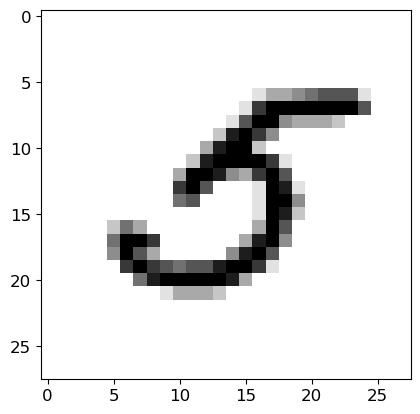

In [14]:
# Visualize the data
plt.imshow(x_train_re[5], cmap=plt.cm.binary)
plt.show()

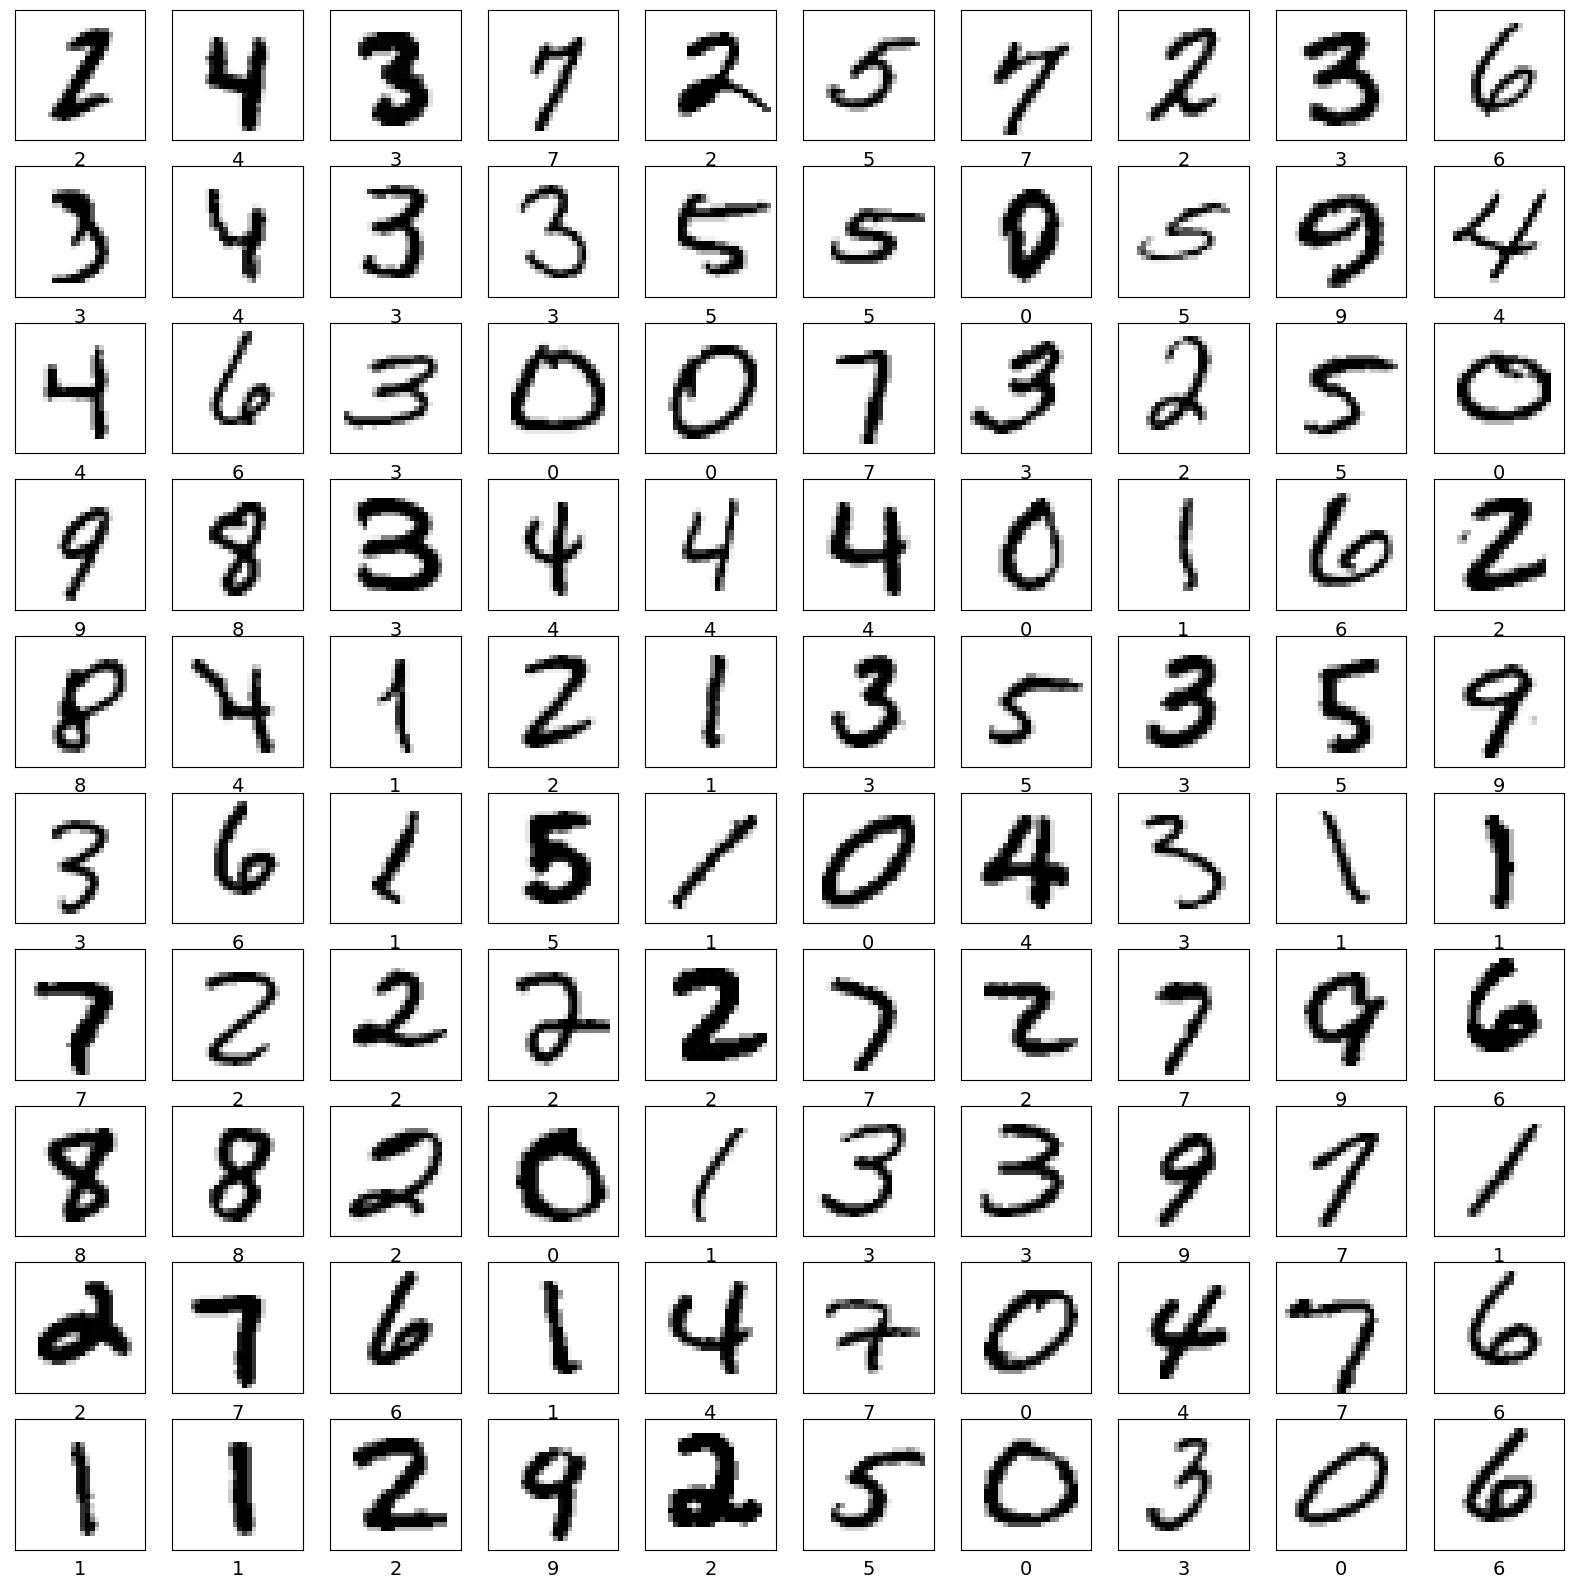

In [15]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_re[i])
plt.show()

In [16]:
# Reshaping train,test and validation data
x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [17]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


In [18]:
# Normalize train,test and validation data
x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

In [19]:
x_train_normalized[3][10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01176471],
       [0.54117647],
       [0.99607843],
       [0.92156863],
       [0.52156863],
       [0.52156863],
       [0.50196078],
       [0.17647059],
       [0.79607843],
       [0.97647059],
       [0.18039216],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [20]:
# Creating input pipeline
train_ds = tf.data.Dataset.from_tensor_slices((x_train_normalized, y_train_re))
train_ds = train_ds.shuffle(10000).batch(50)
valid_ds = tf.data.Dataset.from_tensor_slices((x_validation_normalized, y_validation_re))
valid_ds = valid_ds.batch(50)

In [21]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=15,
    filters=45,
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=10,
    filters=32,
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=7,
    filters=20,
    strides=1,
    activation=tf.keras.activations.relu,
    padding='same',
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(
    units=300,
    activation=tf.keras.activations.relu
));

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 45)        10170     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 45)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        144032    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 20)          31380     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 20)         0

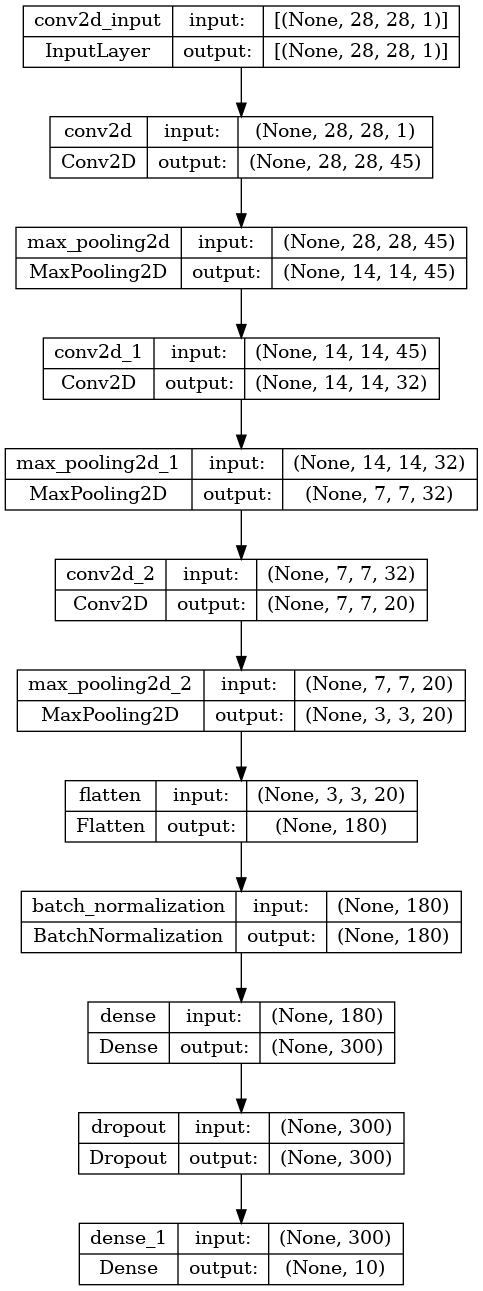

In [23]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [24]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile( loss="sparse_categorical_crossentropy",
               optimizer= adam_optimizer,
               metrics=["accuracy"])

In [25]:
history = model.fit(train_ds, epochs=15, validation_data=valid_ds)

Epoch 1/15
672/672 [==============================] - 21s 9ms/step - loss: 0.1604 - accuracy: 0.9513 - val_loss: 0.2380 - val_accuracy: 0.9295
Epoch 2/15
672/672 [==============================] - 5s 7ms/step - loss: 0.0604 - accuracy: 0.9804 - val_loss: 0.0832 - val_accuracy: 0.9774
Epoch 3/15
672/672 [==============================] - 5s 8ms/step - loss: 0.0407 - accuracy: 0.9871 - val_loss: 0.0530 - val_accuracy: 0.9862
Epoch 4/15
672/672 [==============================] - 5s 7ms/step - loss: 0.0364 - accuracy: 0.9883 - val_loss: 0.1316 - val_accuracy: 0.9664
Epoch 5/15
672/672 [==============================] - 5s 7ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0671 - val_accuracy: 0.9839
Epoch 6/15
672/672 [==============================] - 5s 8ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0603 - val_accuracy: 0.9857
Epoch 7/15
672/672 [==============================] - 5s 7ms/step - loss: 0.0229 - accuracy: 0.9927 - val_loss: 0.0720 - val_accuracy: 0.9821
Epoch

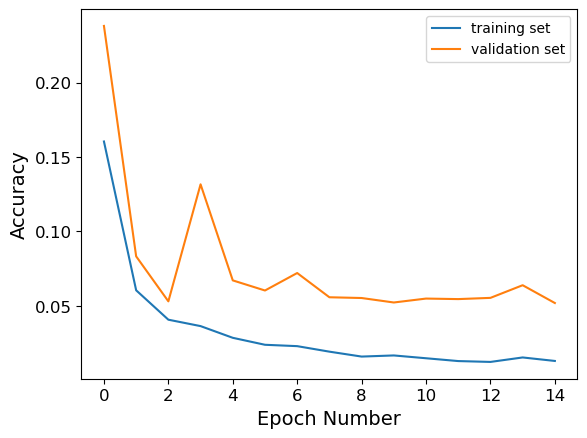

In [26]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='validation set')
plt.legend()

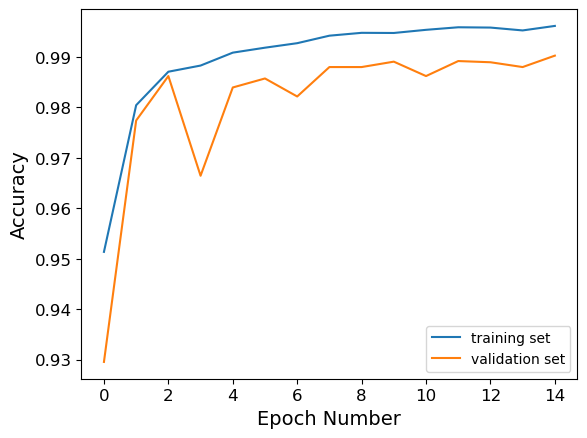

In [27]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='validation set')
plt.legend()

In [28]:
# Performance of Training Dataset
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)

1050/1050 [==============================] - 3s 3ms/step - loss: 0.0056 - accuracy: 0.9982


In [29]:
# Performance of Validation Dataset
validation_loss, validation_accuracy = model.evaluate(x_validation_normalized, y_validation)

263/263 [==============================] - 1s 4ms/step - loss: 0.0519 - accuracy: 0.9902


In [30]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [31]:
loaded_model = tf.keras.models.load_model(model_name)

In [32]:
# Prediction for validation dataset
predictions = loaded_model.predict([x_validation_normalized])

263/263 [==============================] - 1s 2ms/step


In [33]:
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9
0,1.319934e-12,1.000000e+00,1.889487e-10,2.759529e-16,1.096914e-11,1.315693e-17,5.510220e-14,3.223294e-09,2.734102e-13,1.625601e-16
1,1.926197e-23,3.428470e-13,3.960346e-15,1.000000e+00,8.373083e-24,2.453893e-13,5.334232e-22,2.730886e-17,4.826265e-17,9.006538e-18
2,9.455367e-14,1.867412e-11,4.309395e-09,2.646336e-09,3.437992e-12,3.991473e-09,3.249578e-09,2.934138e-12,1.000000e+00,6.607322e-10
3,1.057757e-09,9.999993e-01,4.494480e-09,4.571394e-12,3.346455e-07,5.948651e-11,8.972721e-10,3.881570e-07,6.112021e-09,1.827751e-10
4,1.856096e-10,9.054717e-13,1.582409e-10,3.469180e-09,1.496010e-06,6.160758e-09,2.455832e-11,1.322486e-09,1.133900e-04,9.998851e-01
...,...,...,...,...,...,...,...,...,...,...
8395,4.224843e-24,8.043283e-18,5.058982e-17,3.301517e-22,1.000000e+00,4.827394e-22,1.362531e-17,2.553238e-16,6.153061e-19,2.071543e-16
8396,3.807140e-18,2.589678e-24,2.022416e-21,2.141251e-16,1.149019e-23,1.000000e+00,7.091123e-14,2.989272e-26,1.443034e-17,4.779824e-22
8397,5.550488e-16,3.679562e-11,2.933795e-13,8.177119e-14,3.926635e-11,6.216492e-15,1.297768e-17,1.000000e+00,1.306758e-12,4.166316e-12
8398,1.018219e-07,4.872329e-11,1.352767e-11,2.899944e-11,2.765335e-08,2.290112e-07,9.999996e-01,4.111800e-13,7.462225e-10,1.276900e-13


In [34]:
# Convert predictions in 1D array of integers
predictions = np.argmax(predictions, axis=1)
pd.DataFrame(predictions)

,0
0,1
1,3
2,8
3,1
4,9
...,...
8395,4
8396,5
8397,7
8398,6


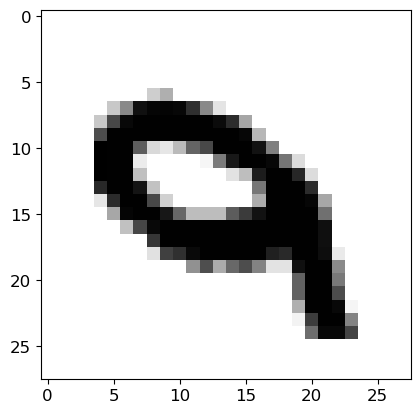

In [35]:
plt.imshow(x_validation_normalized[5].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

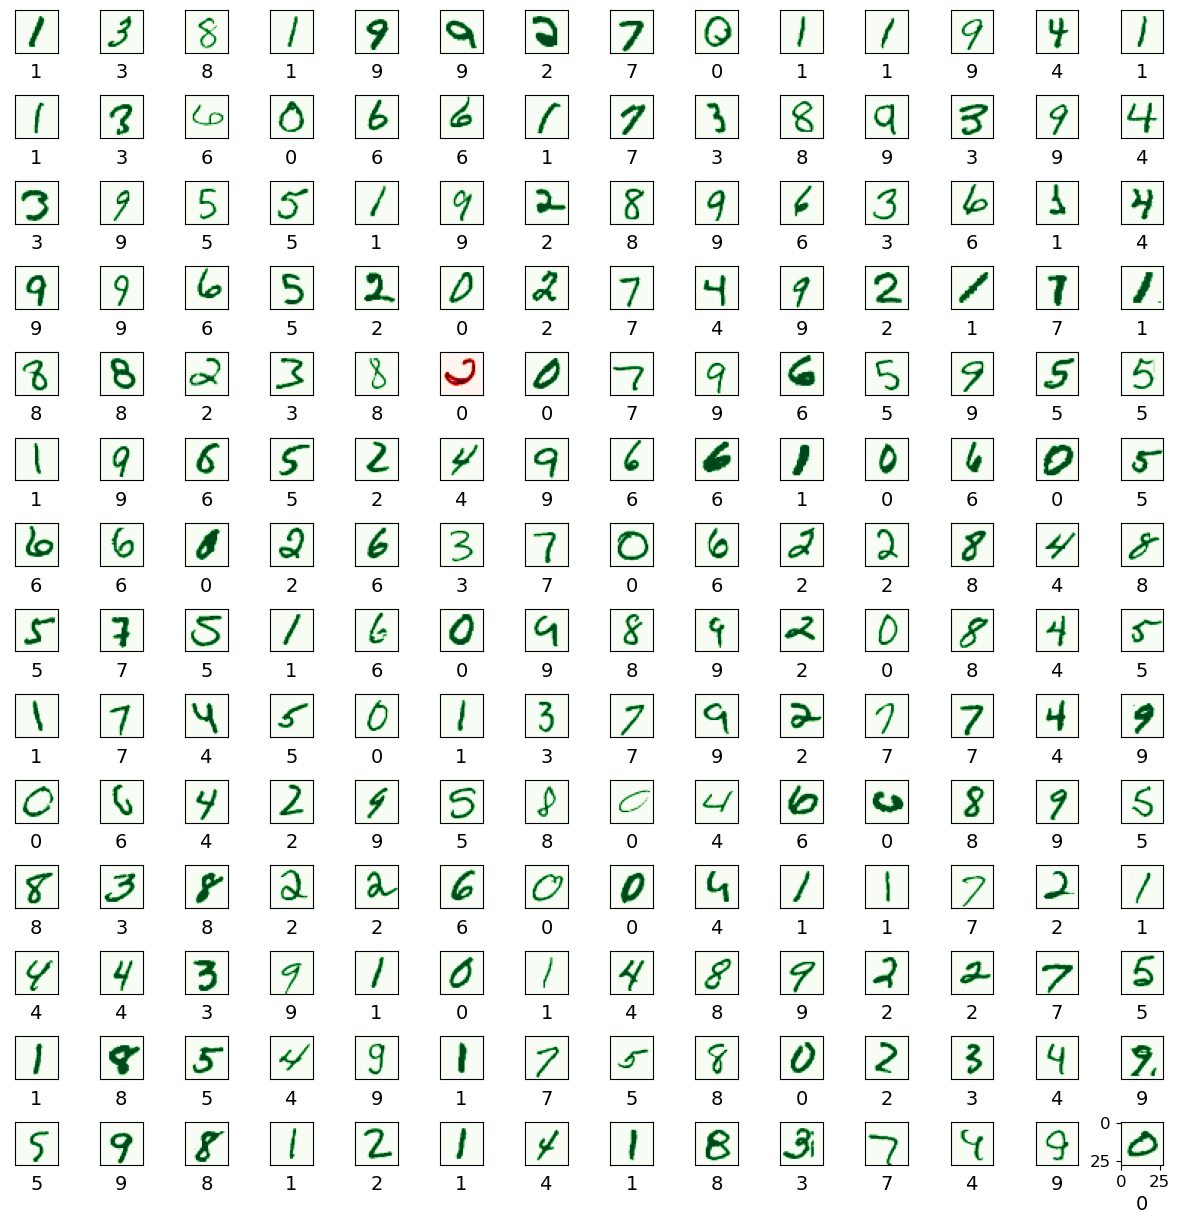

In [36]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_validation_re[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_validation_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [37]:
test_pred = loaded_model.predict([x_test_normalized])

875/875 [==============================] - 2s 3ms/step


In [38]:
pd.DataFrame(test_pred)

,0,1,2,3,4,5,6,7,8,9
0,2.159255e-16,1.517873e-13,1.000000e+00,4.382198e-15,5.845780e-12,1.081107e-20,1.598482e-16,1.768268e-13,2.136968e-15,1.409741e-16
1,1.000000e+00,9.060813e-18,1.567979e-10,1.327477e-13,2.824665e-14,6.279378e-11,1.306642e-10,8.288485e-13,1.683270e-12,3.486203e-12
2,1.516477e-11,1.153960e-12,1.701886e-10,1.473821e-10,3.316698e-06,1.351132e-09,8.241891e-12,4.469082e-11,2.310796e-06,9.999944e-01
3,9.997120e-01,1.318975e-12,7.578256e-09,3.200514e-07,2.019171e-10,8.722545e-07,3.443264e-07,4.505021e-10,2.409521e-06,2.839881e-04
4,2.700474e-15,2.347729e-08,2.796923e-09,1.000000e+00,3.607198e-17,3.303269e-10,1.585277e-13,3.820012e-12,3.453836e-10,1.358813e-12
...,...,...,...,...,...,...,...,...,...,...
27995,2.285883e-10,2.387884e-14,2.705461e-10,1.831794e-10,1.386872e-08,4.129271e-10,5.147112e-14,1.729261e-09,3.334137e-08,1.000000e+00
27996,3.683227e-11,8.284690e-10,2.697032e-10,4.182592e-11,1.297822e-10,4.384471e-12,3.954109e-16,1.000000e+00,8.514340e-12,6.186360e-09
27997,1.602420e-24,2.077330e-14,1.180234e-18,1.000000e+00,8.081448e-26,2.593643e-16,4.992668e-24,3.563446e-17,3.360981e-18,2.448047e-22
27998,2.263961e-10,3.004713e-13,4.969368e-10,1.504969e-09,5.290468e-07,4.209975e-09,2.900617e-12,6.772162e-11,9.844976e-09,9.999995e-01


In [39]:
test_pred = np.argmax(test_pred, axis=1)
pd.DataFrame(test_pred)

,0
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


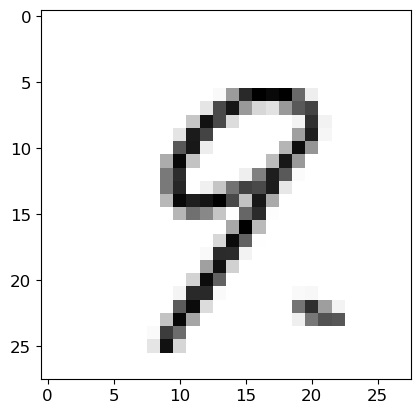

In [40]:
plt.imshow(x_test_normalized[2].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

In [41]:
test_pred.shape

(28000,)

In [42]:
submission_df = pd.DataFrame({'ImageId': range(1, len(test_pred) + 1), 'Label': test_pred})

In [43]:
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [44]:
submission_df.to_csv('submission.csv', index=False)